In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

In [11]:
IMAGE_SIZE = 256
CHANNELS = 3
BATCH_SIZE = 64
EPOCHS = 20
N_CLASSES = 4

In [12]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
   "D:\Deep Learning Project\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 6862 files belonging to 4 classes.


In [13]:
class_names = dataset.class_names
class_names

['Cyst', 'Normal', 'Stone', 'Tumor']

In [14]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(64, 256, 256, 3)
[1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 3 1 0 1 0 2 1 3 3 3 0 0 1 1 1 3 0 3 1 3 1
 1 3 0 1 1 1 1 0 0 3 0 1 0 1 1 0 0 0 0 1 0 1 3 1 0 1 0]


In [15]:
# Create a mapping between numerical labels and class names
class_names = {0: 'Cyst', 1: 'Normal', 2: 'Stone',3:'Tumor'}

unique_labels = set()

for _, labels_batch in dataset.take(1):
    unique_labels.update(labels_batch.numpy())

print("Unique Labels/Classes in the Dataset:", unique_labels)

# Convert numerical labels to class names for visualization
class_names_batch = [class_names[label] for label in labels_batch.numpy()]


Unique Labels/Classes in the Dataset: {0, 1, 2, 3}


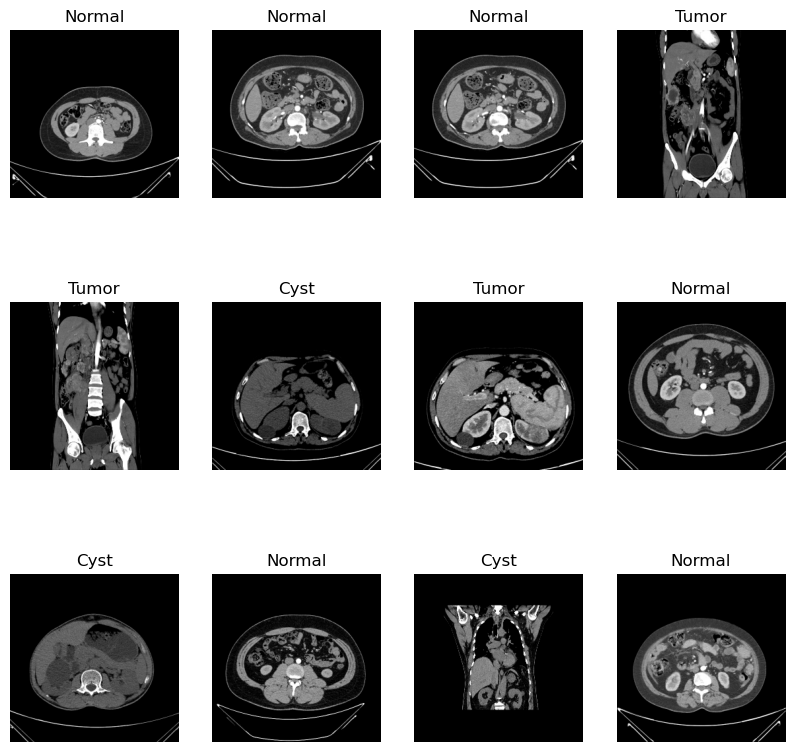

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):  # Display examples from 3 batches
    labels_batch_np = labels_batch.numpy()  # Convert the entire labels_batch tensor to a NumPy array
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)  # 3 batches * 4 subplots per batch
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        
        # Use the NumPy array as an index in the class_names dictionary
        label_key = labels_batch_np[i]
        plt.title(class_names[label_key])
        
        plt.axis("off")

plt.show()

In [17]:
len(dataset)

108

In [18]:
train_size = 0.8
len(dataset)*train_size

86.4

In [30]:
train_ds = dataset.take(86)
len(train_ds)

86

In [31]:
test_ds = dataset.skip(86)
len(test_ds)

22

In [32]:
val_size=0.1
len(dataset)*val_size

10.8

In [33]:
val_ds = test_ds.take(10)
len(val_ds)

10

In [34]:
test_ds = test_ds.skip(10)
len(test_ds)

12

In [35]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [36]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [37]:
len(train_ds)

86

In [38]:
len(val_ds)

10

In [39]:
len(test_ds)

12

In [40]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [41]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [42]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.4), 
])

In [43]:
train_ds_augmented = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [44]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [45]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (64, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (64, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (64, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (64, 60, 60, 64)         

In [46]:
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     patience=10,  # Adjust the patience parameter
#     restore_best_weights=True,
#     monitor='val_loss'
# )

In [47]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adjust the learning rate
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [48]:
  history = model.fit(
        train_ds_augmented,
        batch_size=BATCH_SIZE,
        validation_data=val_ds,
        verbose=1,
        epochs=EPOCHS,
        #callbacks=[early_stopping]
    )

Epoch 1/20
86/86 [==============================] - 166s 2s/step - loss: 0.9319 - accuracy: 0.6384 - val_loss: 0.8395 - val_accuracy: 0.6828
Epoch 2/20
86/86 [==============================] - 141s 2s/step - loss: 0.6934 - accuracy: 0.7389 - val_loss: 0.9414 - val_accuracy: 0.6469
Epoch 3/20
86/86 [==============================] - 140s 2s/step - loss: 0.5403 - accuracy: 0.7948 - val_loss: 0.8791 - val_accuracy: 0.6875
Epoch 4/20
86/86 [==============================] - 138s 2s/step - loss: 0.4268 - accuracy: 0.8309 - val_loss: 1.0290 - val_accuracy: 0.7125
Epoch 5/20
86/86 [==============================] - 139s 2s/step - loss: 0.3892 - accuracy: 0.8445 - val_loss: 0.9481 - val_accuracy: 0.7469
Epoch 6/20
86/86 [==============================] - 139s 2s/step - loss: 0.3338 - accuracy: 0.8575 - val_loss: 1.0470 - val_accuracy: 0.7484
Epoch 7/20
86/86 [==============================] - 135s 2s/step - loss: 0.3200 - accuracy: 0.8625 - val_loss: 0.7478 - val_accuracy: 0.7828
Epoch 8/20
86

In [49]:
scores = model.evaluate(test_ds)

12/12 [==============================] - 15s 476ms/step - loss: 0.6113 - accuracy: 0.8372


In [50]:
score = model.evaluate(train_ds)

86/86 [==============================] - 41s 474ms/step - loss: 0.5189 - accuracy: 0.8550


In [51]:
scores

[0.6113339066505432, 0.8372395634651184]

In [52]:
history

In [53]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 86}

In [54]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [55]:
type(history.history['loss'])

list

In [56]:
len(history.history['loss'])

20

In [57]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9318910241127014,
 0.6934370994567871,
 0.5403221249580383,
 0.4268020689487457,
 0.38920488953590393]

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

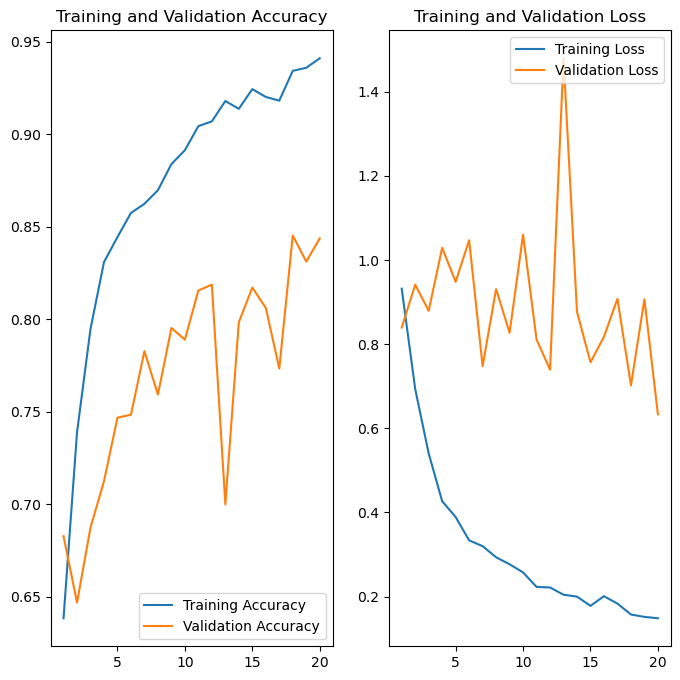

In [59]:
epochs = range(1, len(acc) + 1)  

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

first image to predict
actual label: Cyst
2/2 [==============================] - 1s 216ms/step
predicted label: Cyst


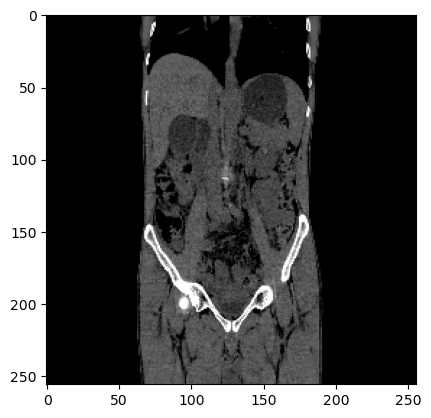

In [60]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    

In [61]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 24ms/step


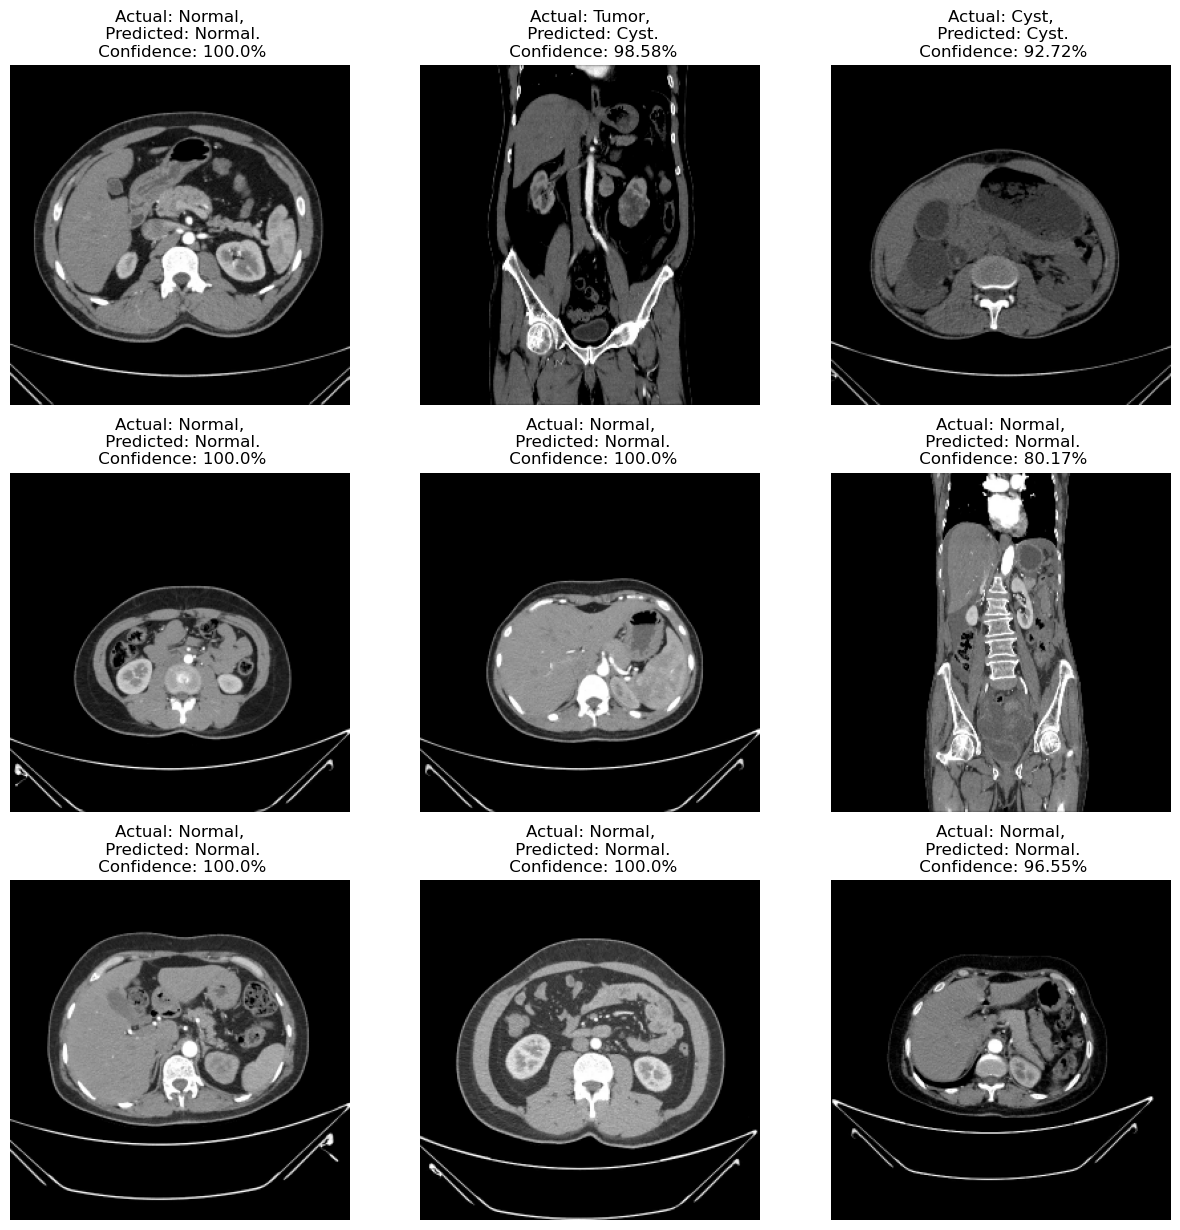

In [62]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i].numpy()]

        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [63]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Assuming you have a list to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Collect all unique class names from the training dataset
all_class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']
label_encoder.fit(all_class_names)  

# Iterate through the test dataset to collect true and predicted labels
for images, labels in test_ds:
    for i in range(len(images)):
        try:
            true_labels.append(label_encoder.transform([class_names[labels[i].numpy()]])[0])
        except KeyError:
            # Handle unseen label gracefully
            print(f"Unseen label: {class_names[labels[i].numpy()]}")
            continue
        
        # Using your predict function
        predicted_class, _ = predict(model, images[i].numpy())
        predicted_labels.append(label_encoder.transform([predicted_class])[0])

# Convert lists to numpy arrays for precision calculation
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate precision, recall, and f1-score with zero_division parameter
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=1)
f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=1)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')




1/1 [==============================] - 0s 22ms/step
Precision: 0.85
Recall: 0.84
F1-score: 0.82


In [64]:
# Calculate precision with zero_division parameter
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1)

print(f'Precision: {precision:.2f}')

Precision: 0.85


In [65]:
# Calculate recall with zero_division parameter
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=1)

print(f'Recall: {recall:.2f}')

Recall: 0.84


In [66]:
# Calculate precision with zero_division parameter
f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=1)
print(f'F1-score: {f1:.2f}')

F1-score: 0.82


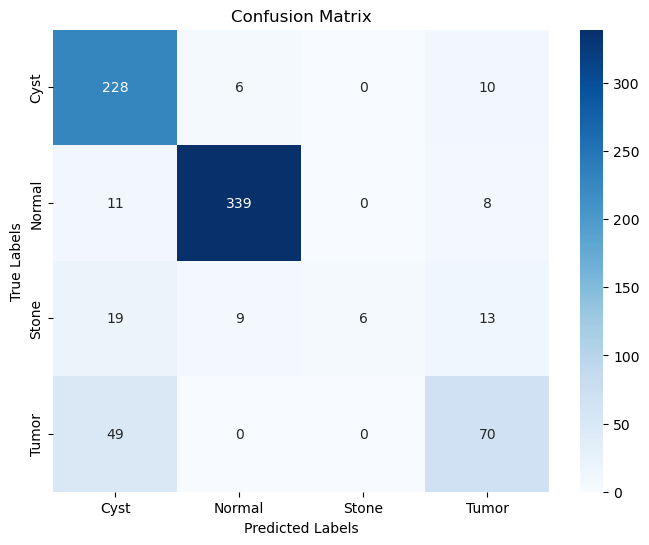

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have true_labels and predicted_labels

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class names for visualization
class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()